# Component Creation with Landlab

*This notebook, which was created for a clinic at the May 2022 CSDMS All-Hands Meeting, explores how to fully engage with the Landlab library by creating your own components. It is designed for those who already have some basic familiarity with Landlab and with scientific Python programming.*

*(Eric Hutton and Greg Tucker, CSDMS / CU Boulder, May 2022)*

## Introduction to Landlab Components

A "potluck supper" is a common American tradition in which each guest brights a dish to share. These contributed dishes usually come in one of a few categories: salads, drinks,  main dishes, desserts. The meal comes together as a collection of components, each of which contributes to fulfilling one of these basic roles. The resulting meal provides guests with a great variety of choices. A guest can compose their own complete and unique meal by combining their own choices for components. And each guest, while contributing their own particular dish, get to share in the creations of their compatriots. There's a bit of standardization---the dishes are sized to fit on the tables, and their contents are accessible to the usual range of serving utensils---but with that standardization lies a great range of creativity.

Component modeling is a bit like the potluck tradition: one can construct a complete simulation by assembling components to represent the different parts of the system to be modeled. In Landlab, a **component** is a semi-standardized Python *class* that represents a particular process or calculation. Components are not stand-alone programs, but rather are designed to be used within another Python program that creates an integrated model or workflow.

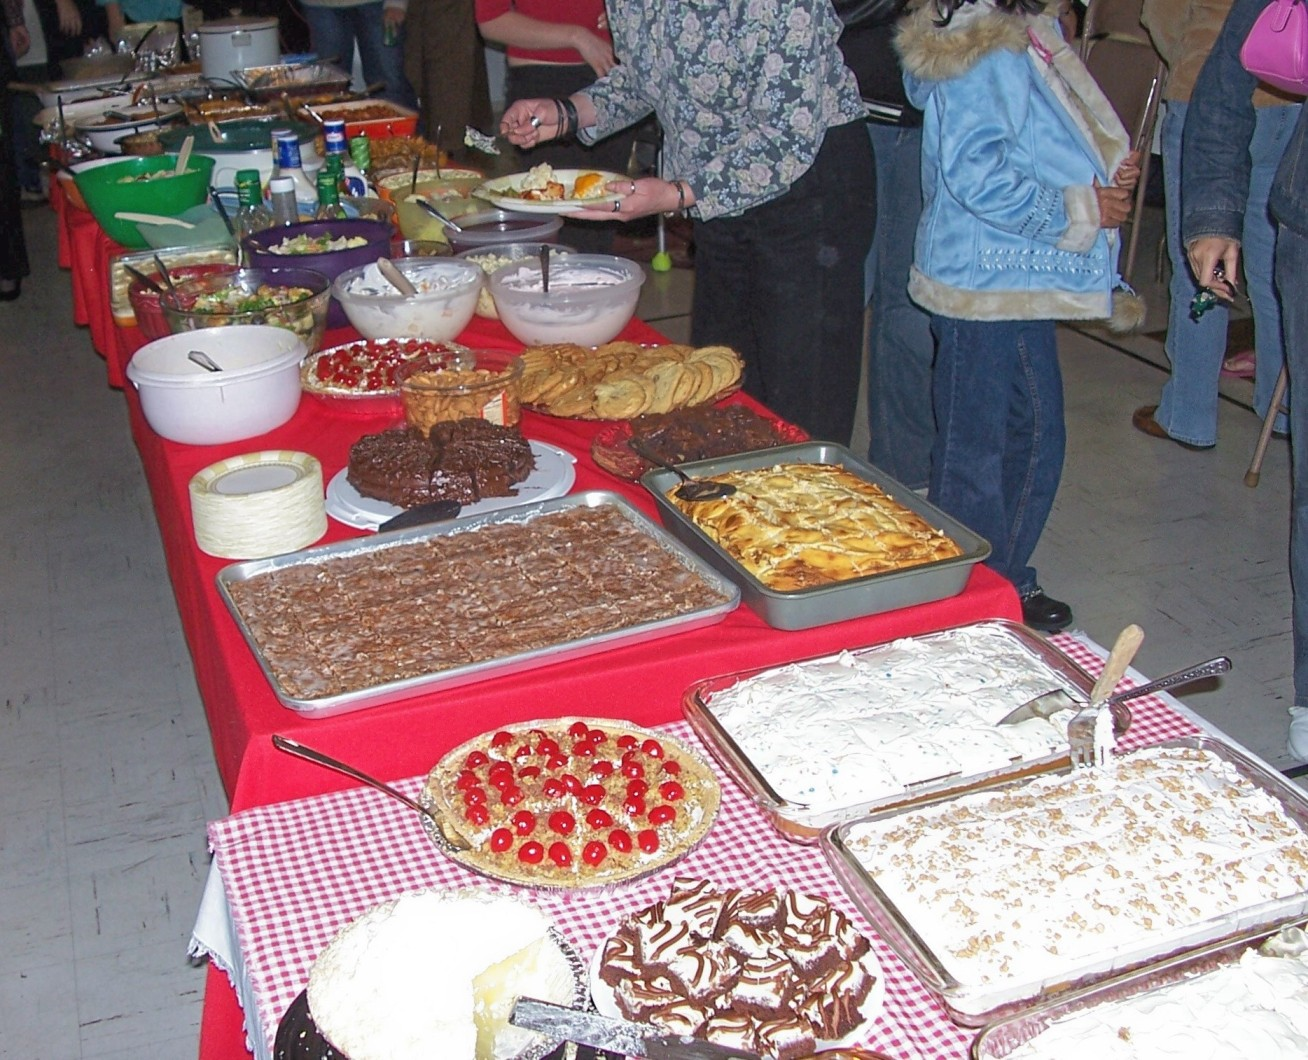
*Figure 1: A potluck meal (wikimedia commons).*


### Examples of Landlab Components

#### Infiltration and overland flow

Here's an example from the Landlab tutorial *Green-Ampt infiltration and kinematic wave overland flow*. The example code in the tutorial uses two components, `SoilInfiltrationGreenAmpt` and `KinwaveImplicitOverlandFlow`, to calculate overland flow and infiltration across a terrain that is represented by a digital elevation model.

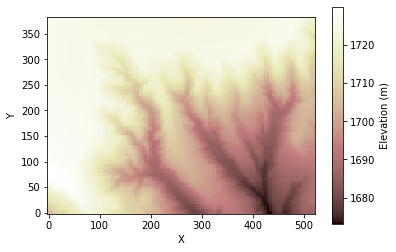
*Figure 2: topography of a gullied area on the Colorado high plains (from Landlab tutorial "Green-Ampt infiltration and kinematic wave overland flow").*



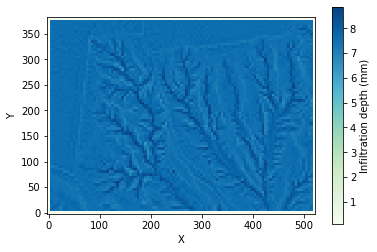

*Figure 3: cumulative infiltration water depth during a simulated five-minute heavy rainfall (from Landlab tutorial "Green-Ampt infiltration and kinematic wave overland flow")*

The following code snippets illustrate how the components are imported...

```python
from landlab.components import (
    SoilInfiltrationGreenAmpt,
    KinwaveImplicitOverlandFlow
)
```

...instantiated...

```python
ga = SoilInfiltrationGreenAmpt(grid)

kw = KinwaveImplicitOverlandFlow(
    grid, runoff_rate=90.0, roughness=0.1, depth_exp=5.0 / 3.0
)
```

...and run in a time loop:

```python
for i in range(nsteps):
    kw.run_one_step(dt)
    ga.run_one_step(dt)
```

#### Eroding volcanic island

The image below shows a snapshot from a simulation of a volcanic island. The code was written using Landlab components in a Jupyter notebook, by a group of graduate students at CU Boulder as part of a 1-credit seminar on landscape evolution modeling.

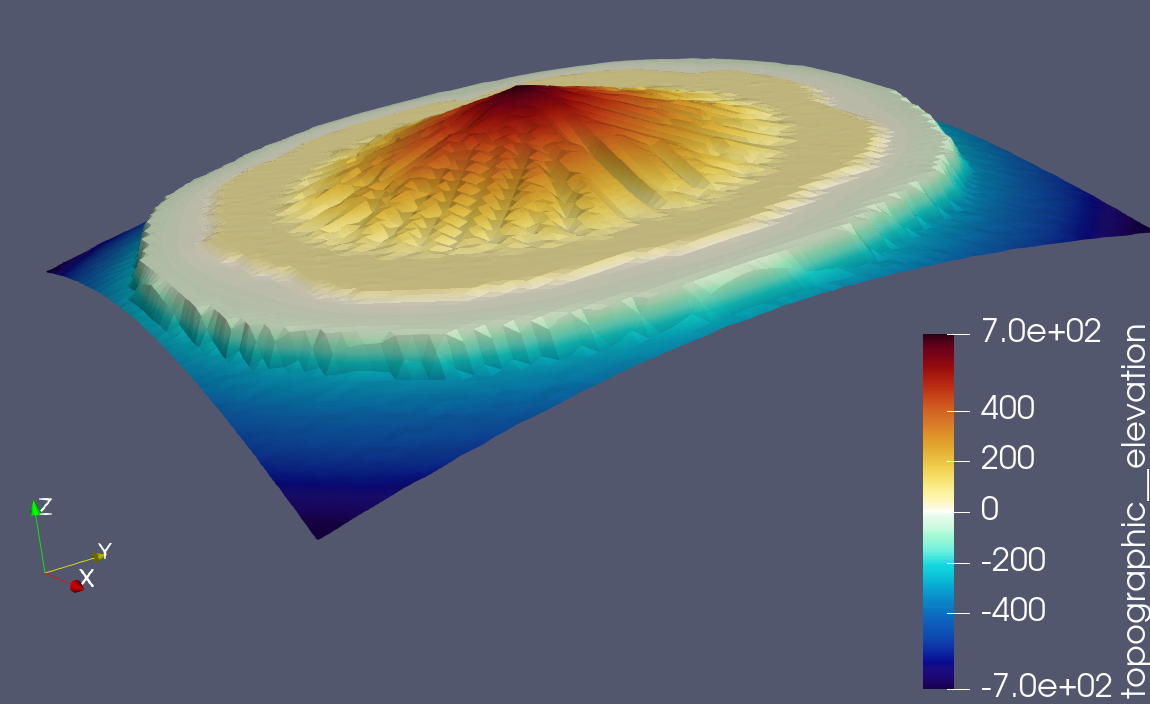

*Figure 4: example snapshot from a component-built Landlab model of volcanic island geomorphic evolution (source code at [https://github.com/CU-Boulder-Computational-Geomorphology/volcanic-island-model](https://github.com/CU-Boulder-Computational-Geomorphology/volcanic-island-model)).*

### Architecture of a component-based Landlab model

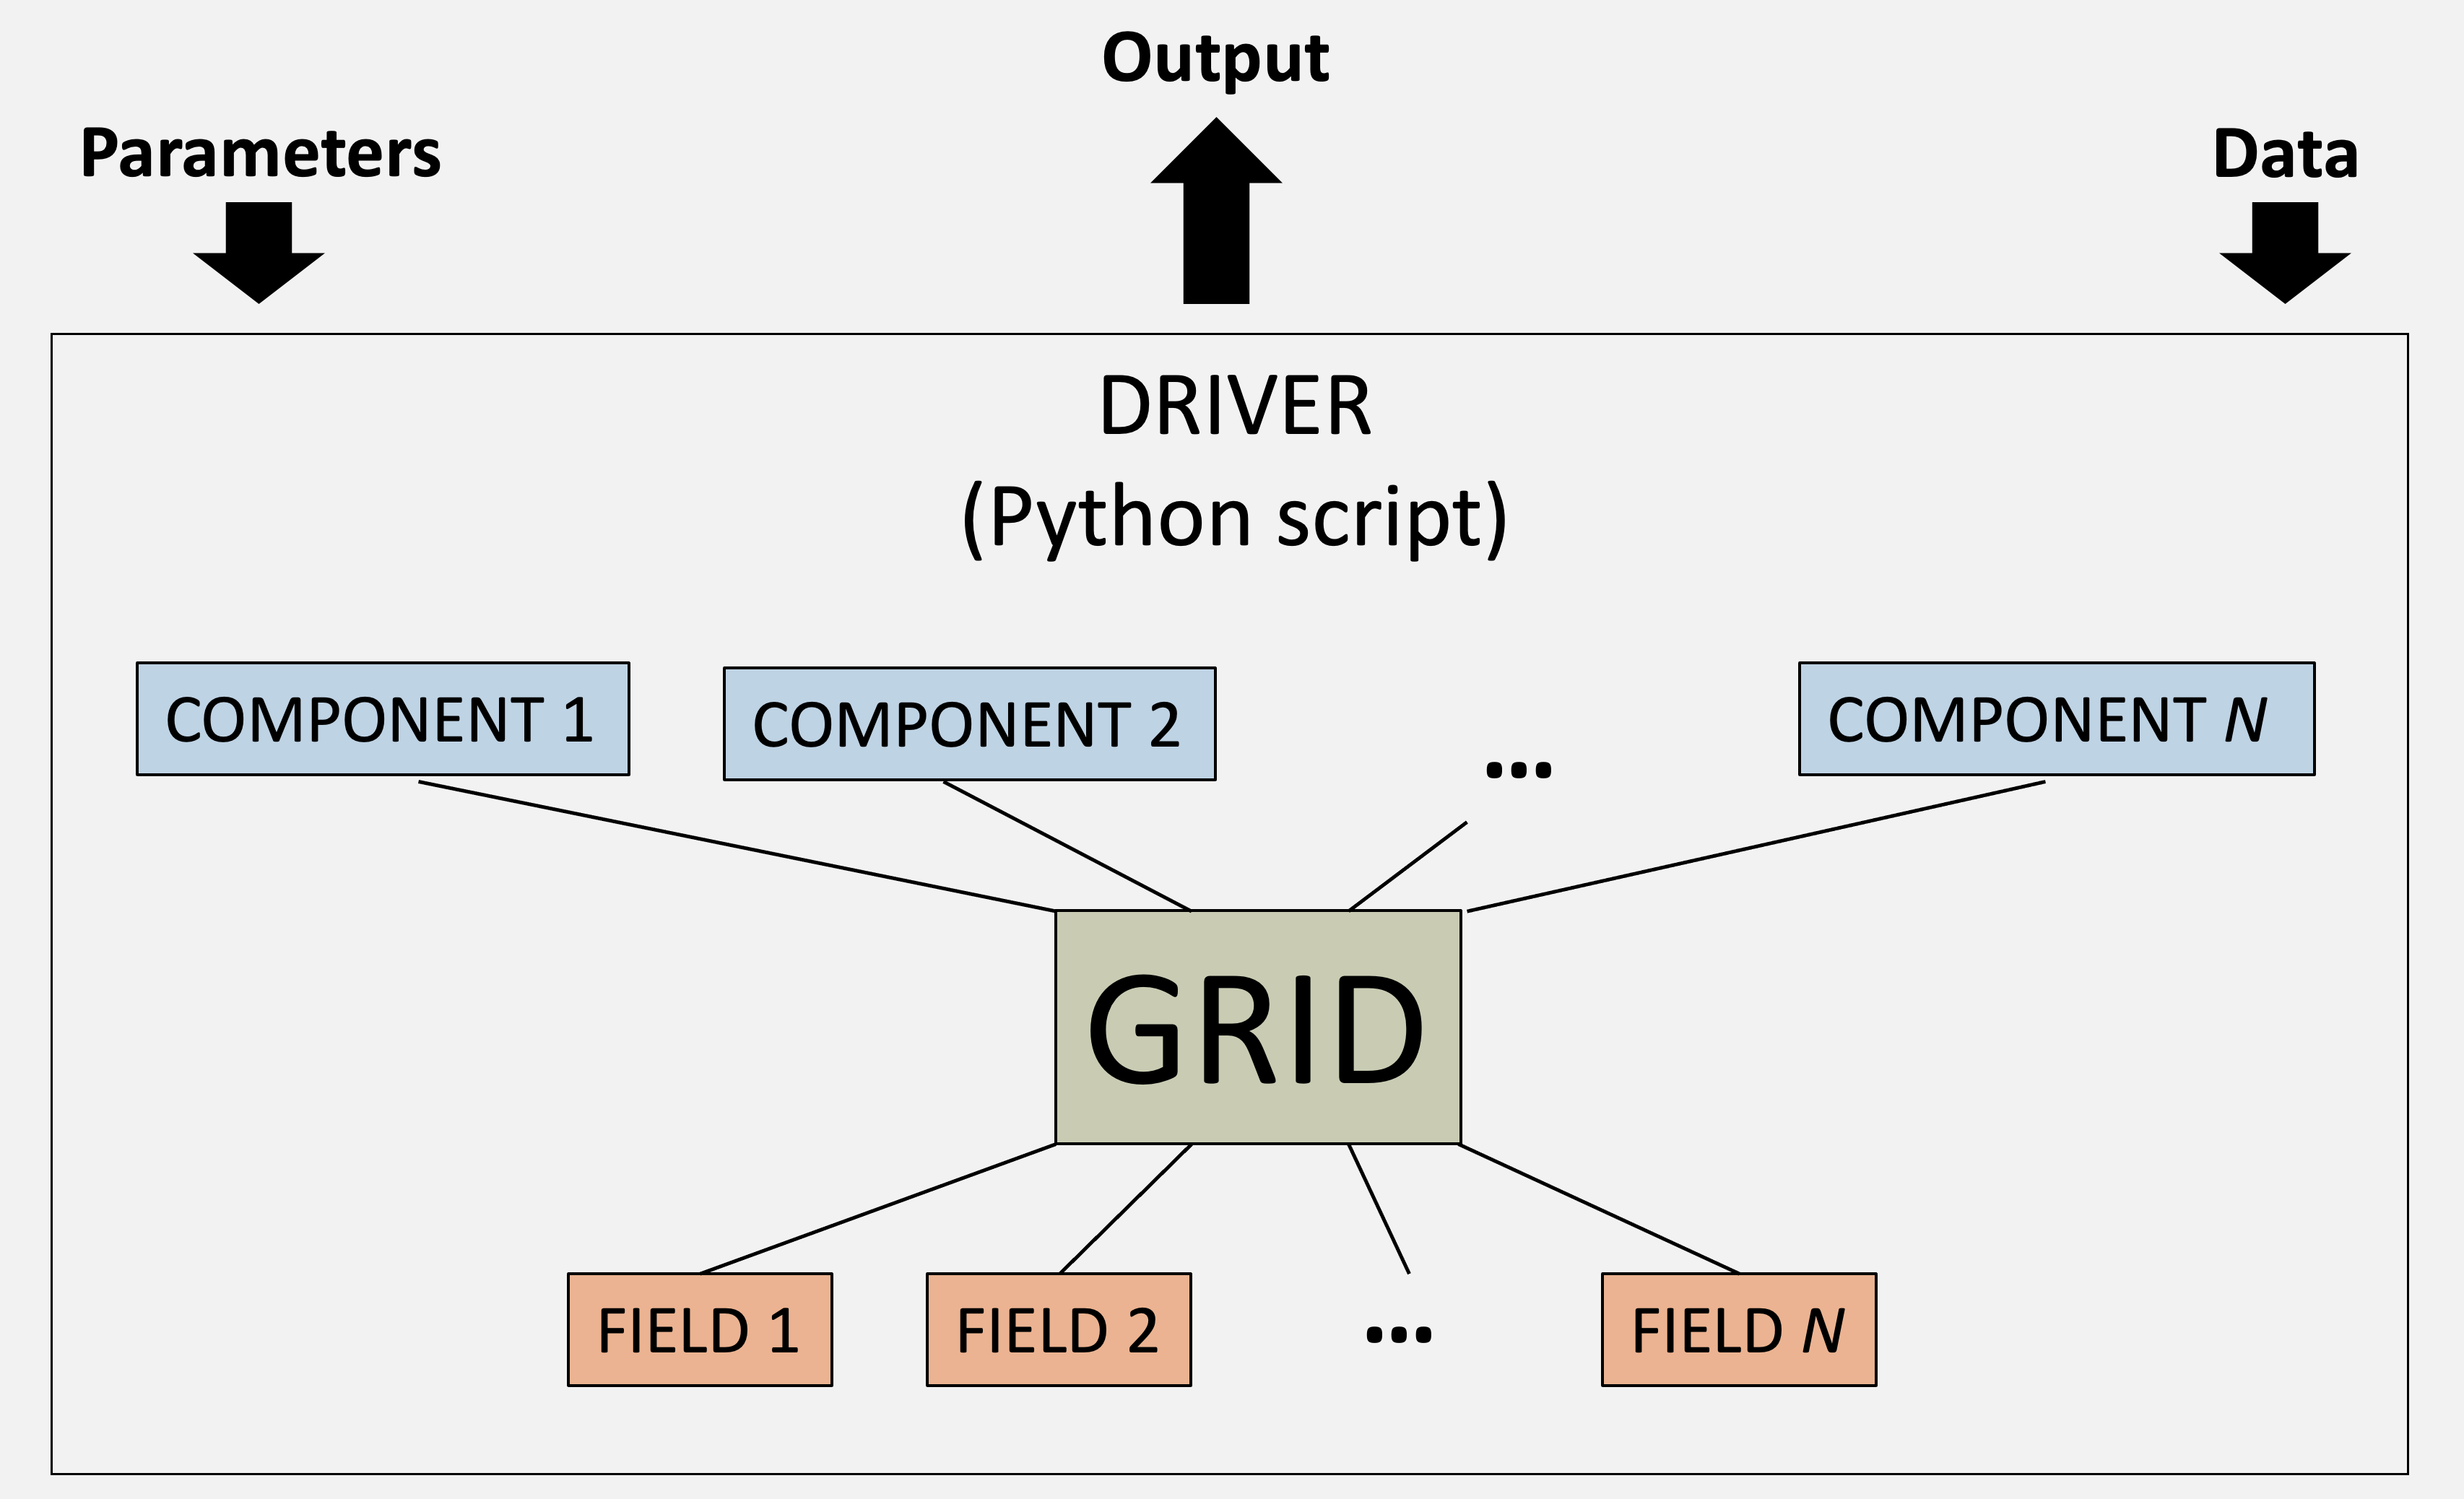

*Figure 5: schematic illustration of a component-based Landlab model, showing how the model code integrates a Grid object with one or more Components along with Fields data.*

### Components: what and why?

A Landlab component is a semi-standardized Python **class** that either implements a numerical-model representation for an individual process, or performs a calculation on an input data set. Landlab components are normally not stand-alone programs; instead, a *driver* program (Figure 5) imports, instantiates, and operates one or more components as part of an integrated model or analysis script. Most Landlab components require a **grid** object, and possibly one or more input **fields**, in order to operate. Landlab components inherit from a base class called `Component`, which provides some useful common functionality and attributes.

Some advantages of using components:

- Easier to re-use code
- Easier to experiment with alternative representations for different processes, or alternative implementations of a given algorithm
- Easier to create integrated, multi-process models

### The Landlab component collection

The current (spring 2022) collection of components spans a variety of types of process and analysis. You can find a list [in the documentation](https://landlab.readthedocs.io/en/latest/reference/components/index.html).

To see a list, you can use the following python commands:

In [ ]:
from landlab.components import COMPONENTS

[component.__name__ for component in COMPONENTS]

## Anatomy of a Landlab component

A Landlab component:

- Is a Python class that inherits from `Component`
- Has a class docstring that describes what the component does
- Has header data that lists its input and output **fields**
- Has an `__init__` method whose arguments include a Landlab **grid** and any component-specific parameters
- Has an action method, often called `run_one_step`, that performs the component's main action, such as advancing a numerical solution forward in time by a given duration

Using a component involves:

- Importing it
- Instantiating it
- Calling its action method (often but not always inside a time loop)


## Building a Landlab component

Here we'll build a Landlab component to model soil creep, which is the gradual downslope movement of soil on hillslopes. This process is often approximated by a rate law that represents the long-term average down-slope volume flux of soil as a linear function of local slope gradient. When combined with mass conservation, this leads to a diffusion-like equation.

### Example: linear diffusion theory for soil creep on hillslopes

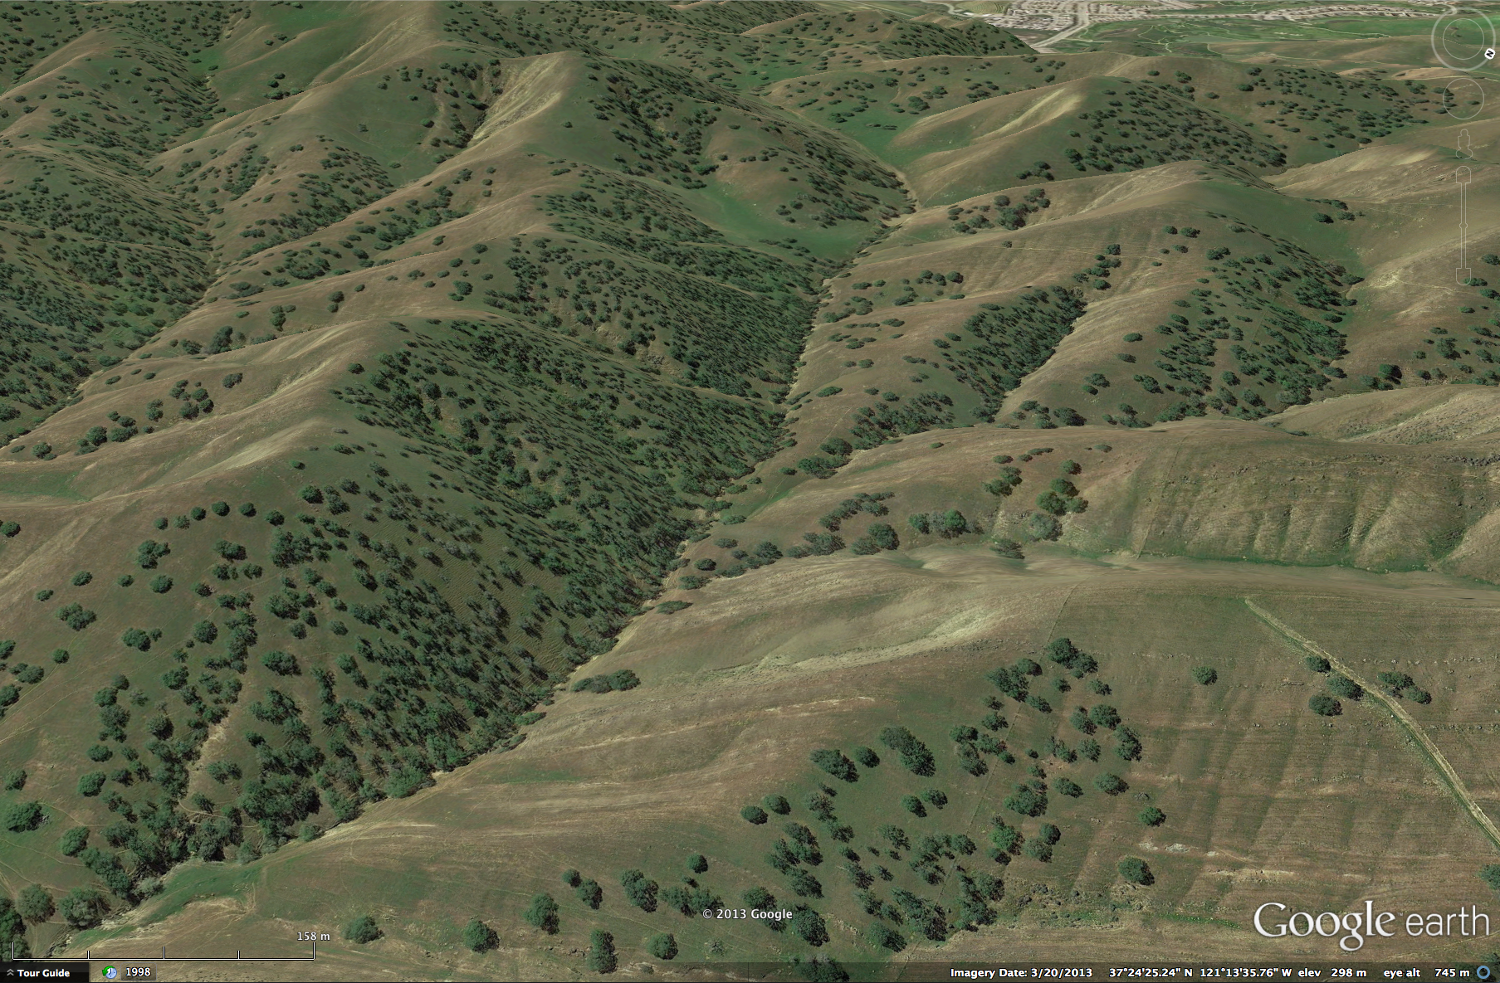

Here we'll introduce a simple mathematical model for soil transport on relatively gentle, soil-mantled hillslopes. The theory has two parts: a mass conservation equation (here with a source term representing vertical motion of material at rate $U$ relative to a baselevel reference frame),

$$\large \frac{\partial z}{\partial t} = U - \nabla\cdot \mathbf{q}$$

where $z$ is land height [with dimensions of length, here denoted L], $t$ is time [with dimensions of time, of course, here denoted T], $U$ is baselevel lowering rate [with dimensions of speed, or L/T], $\mathbf{q}$ is the bulk soil flux [L$^2$/T], and $\nabla$ is the gradient operator in two horizontal spatial dimensions.

The second part specifies $\mathbf{q}$. For low-gradient, soil-mantled slopes, the down-slope soil flux can be approximated as a linear function of the slope gradient:

$$\large \mathbf{q} = -D \nabla z$$

where $D$ is a transport coefficient with dimensions of length squared per time (field studies suggest its values range from about $10^{-4}$ to a bit more than $10^{-2}$ m$^2$/yr). Combining these yields a 2D diffusion equation:

$$\large \frac{\partial z}{\partial t} = U + D\nabla^2 z$$

### Finite-volume numerical setup (staggered grid)

One way to solve 2d diffusion is to use a **finite volume** method, in which height is solved at *nodes*, which sit inside *cells*. The rate of change of soil volume depends on the influx of outflux of soil across the cell *faces*. Here's an example of one cell:

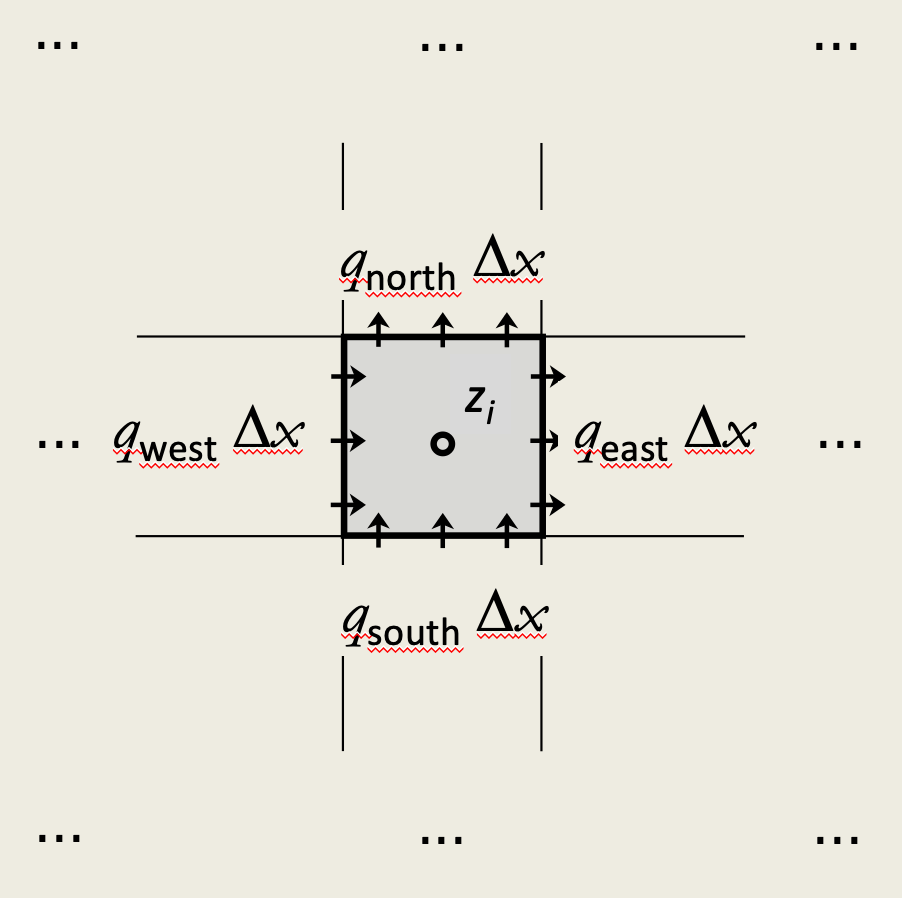

Mass conservation for cell $i$ can be written:

$$\large \frac{d z_i}{\partial t} = U + \frac{\Delta x}{\Delta x^2}\left( q_\text{west} + q_\text{south} - q_\text{east} - q_\text{north}\right)$$

Of course, one of the $\Delta x$ factors cancels on on the right side: they are included here to remind us that the top $\Delta x$ represents the width of faces (which we multiple by $q$ to get volume of soil per year across each cell face), and the bottom $\Delta x^2$ is the area of the cell.

We can write this more compactly (for a square grid):

$$\large \frac{d z_i}{\partial t} = U + \frac{1}{\Delta x^2} \sum_{j=0}^3 \delta_j q_j \Delta x$$

where $q_j$ is the volume flux per width along the $j$-th link, and $\delta$ is a direction indicator, equal to +1 if the link points into the cell, and -1 if the link points out of the cell.

-------
*Fun fact: the layout above is identical to a staggered-grid finite-difference scheme. But the advantage of a finite-volume set up is that we can generalize it to a non-square grids, in which the surface area of a given cell is $\Lambda$, the width of a given face is $\lambda$, and the number of neighboring nodes adjacent to node $i$ (equal to the number of faces and links) is $N_i$. The above becomes:*

$$\large \frac{d z_i}{\partial t} = U + \frac{1}{\Lambda_i} \sum_{j=0}^{N_i-1} \delta_j q_j \lambda_j$$


--------

To implement this method for soil creep on a Landlab grid, we track height values at the grid *nodes*, and gradients and fluxes ($q$) at the grid *links*. Note that each link has a direction as well as a position, and the associated direction indicators $\delta$ is also stored as part of the **grid** object (the rule for link directions is that they always point toward the upper-right quadrant, that is, between -45$^\circ$ and +135$^\circ$ as measured counter-clockwise from the positive $x$ axis).

Here's some Landlab code that illustrates nodes, cells, faces, and links for a 4 x 5 raster grid:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.plot.graph import plot_graph

In [ ]:
# create a small grid
grid = RasterModelGrid((4, 5), xy_spacing=1.0)

# plot the link midpoints as blue diamonds
tails = grid.node_at_link_tail
heads = grid.node_at_link_head
linkx = 0.5 * (grid.x_of_node[tails] + grid.x_of_node[heads])
linky = 0.5 * (grid.y_of_node[tails] + grid.y_of_node[heads])
plt.plot(linkx, linky, 'bD')

# plot nodes (red circles), links (blue arrows), 
# faces (dashed arrows)
plot_graph(grid, at="node,link,face", with_id=None)

Here nodes (like roses) are in red and link midpoints (like violets, or so they say) are in blue. In our component, height values will be calculated and stored at nodes, and gradient and flux ($q$) values will be calculated and stored at links.

You can also view the arrangements of grid elements interactively with the [Landlab Grid Sketchbook (https://landlab.github.io/grid-sketchbook)](https://landlab.github.io/grid-sketchbook).

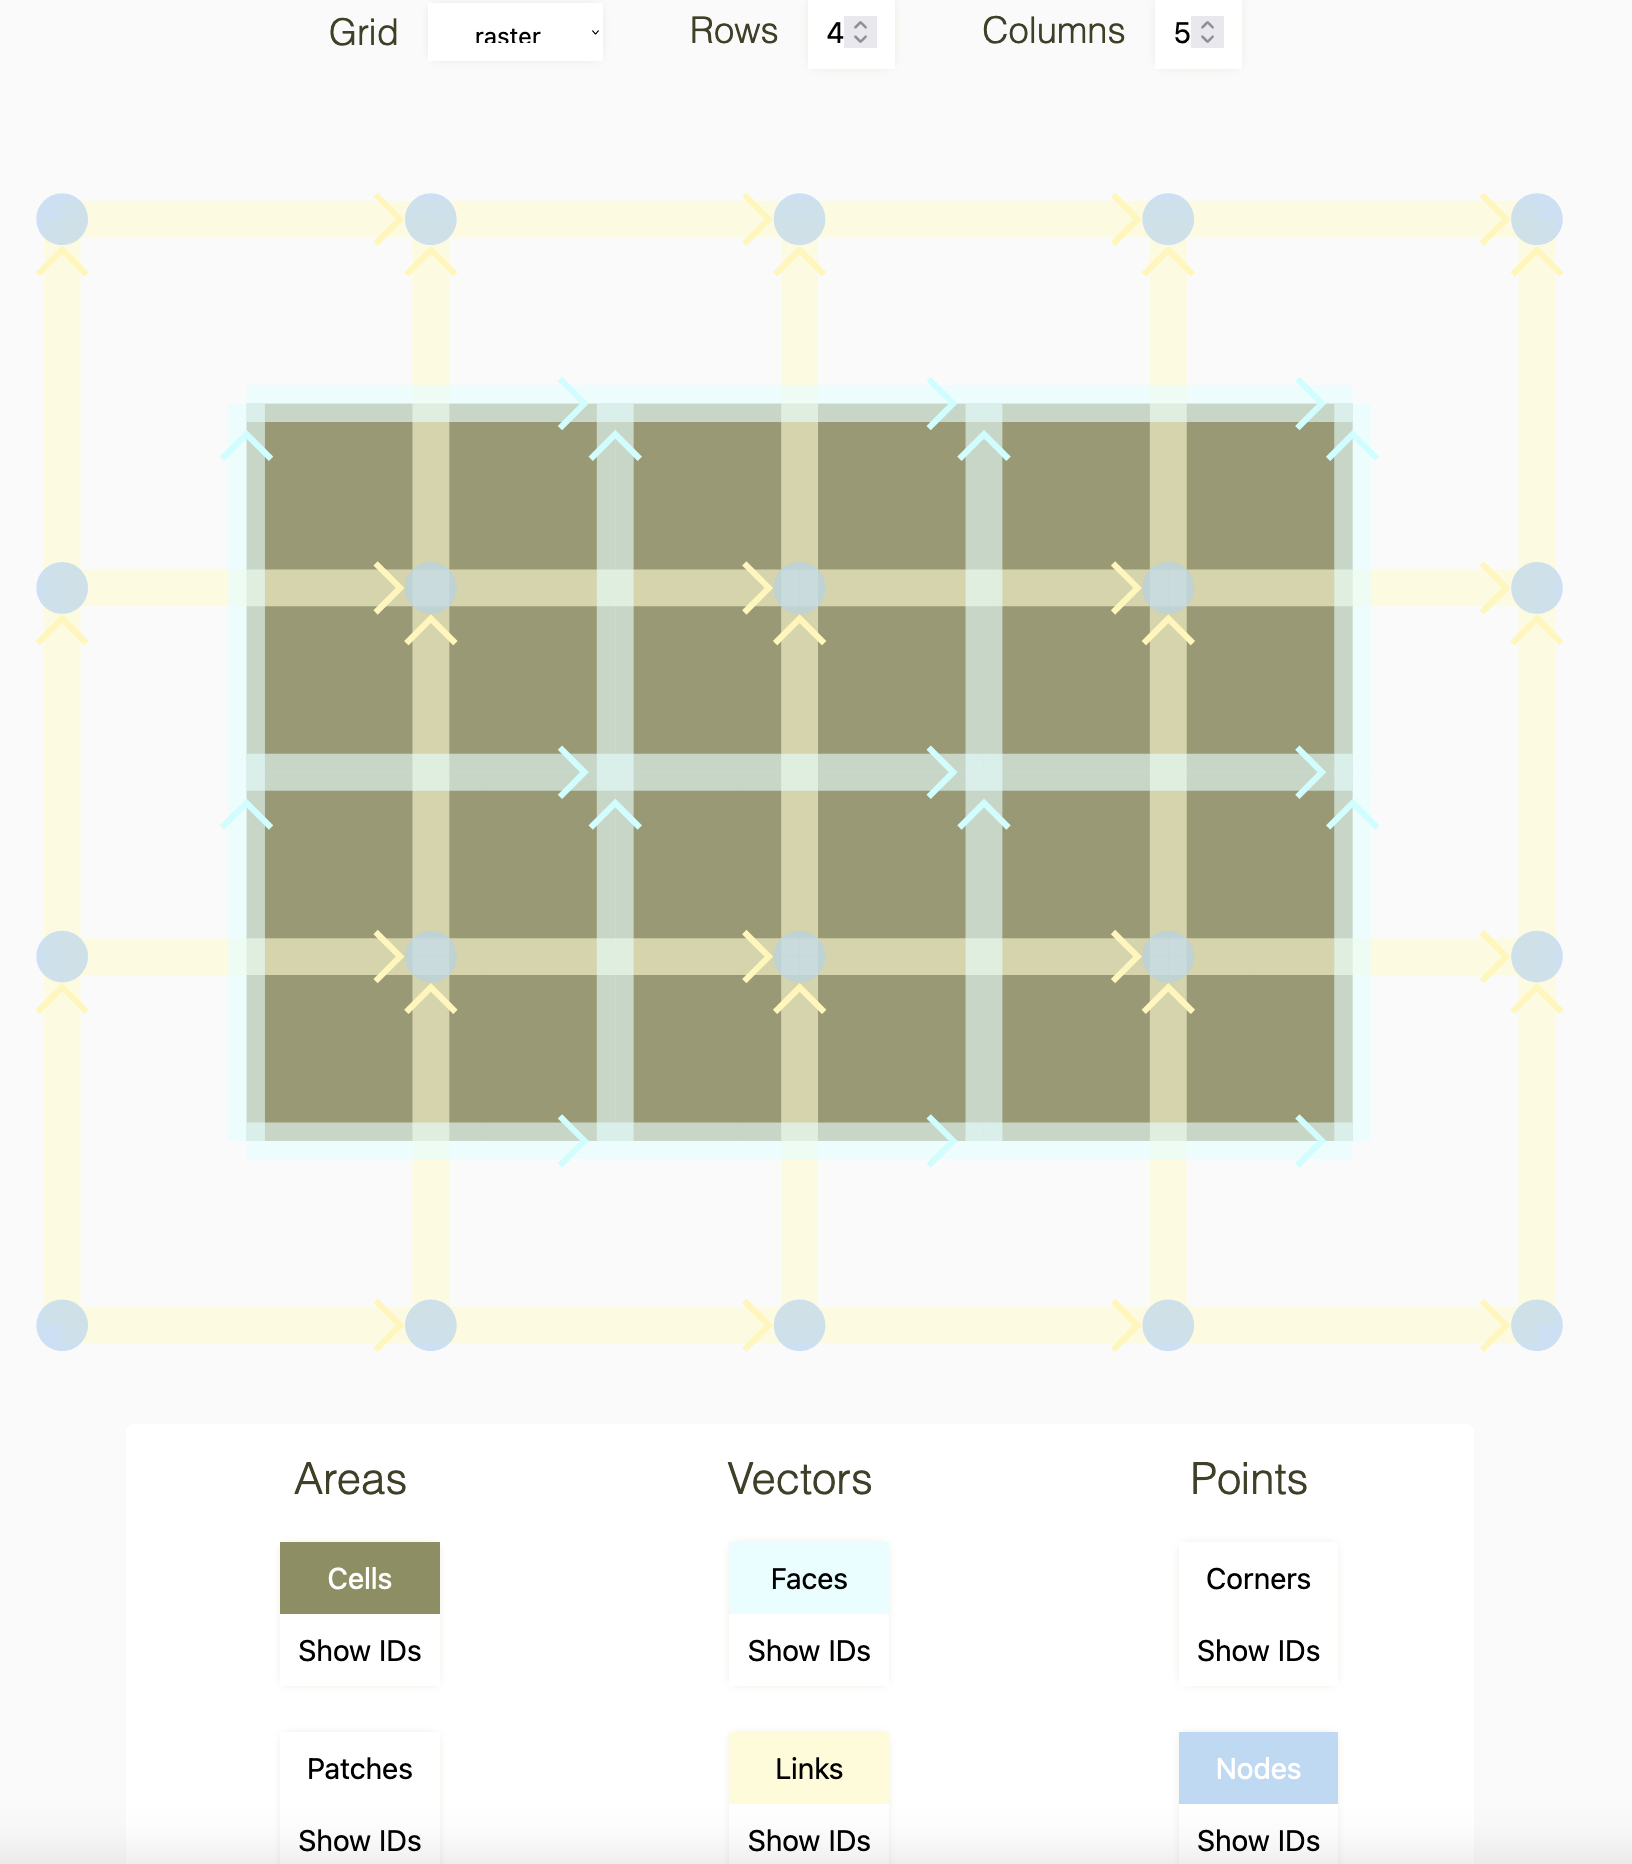



Now, on to some code!